<a href="https://colab.research.google.com/github/AlexandreCandidoXavier/BR-DWGD/blob/main/notebooks/exemplo_google_earth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalhando com dados pontuais no Google Earth
Neste exemplo, para obtenção dos dados de um ponto,
não será necessário baixar os arquivos Netcdf. Estes serão adquiridos via a 
plataforma [Google Earth Engine](https://earthengine.google.com/), disponibilizados
em [awesome-gee-community-catalog](https://gee-community-catalog.org/projects/br_dwgd/).

Vamos trabalhar com a variável precipitação para uma posição geográfica, 
nos níveis de tempo: diário, mensal e anual.

Para rodar será necessário fazer uma cópia deste *notebook* no seu computador ou no seu 
*Google Drive*, se estiver utilizando o **Colab** (Menu File -> Save copy in Drive).

In [1]:
# instalando geemap atualizado (https://geemap.org/):
# %pip install -U geemap

In [1]:
import ee
import geemap
import numpy as np
import datetime
import pandas as pd
import plotly.express as px

Vai pedir a autentificação (tem que ter conta gmail)

In [2]:
# ee.Authenticate()

In [3]:
ee.Initialize()

In [4]:
m = geemap.Map()

Pegando variável precipitação e reescalonando.

Para as demais: variáveis: https://gee-community-catalog.org/projects/br_dwgd/

In [5]:
var = ee.ImageCollection("projects/sat-io/open-datasets/BR-DWGD/PR")
# var = ee.ImageCollection("projects/sat-io/open-datasets/BR-DWGD/PR").filterDate('2020-12-10', '2020-12-30')
# print(var.aggregate_array('system:id').getInfo())

Reescalonar

In [6]:
offset = 225
scale  = 0.006866665

# reescalonando
def scaleBand(image):
    scaledImage = image.select("b1").rename(['pr']).multiply(scale).add(offset) \
                       .set({'date': image.date().format('yyyy-MM-dd')}) 
    return scaledImage.copyProperties(image, image.propertyNames())

var = var.map(scaleBand)

# informações para plotar o mapa da precipitação
color_pal = ['000066', '001199', '0044BB', '0077DD', '33AAEE', '66CCFF', 'FFDDCC', 'FFBB99', 'FF9966', 'FF6644']
vis = {'min': 0,'max': 70, 'palette': color_pal}

# definindo período (tem limite)
start_date, end_date = '1961-01-01','2023-01-01' #'2010-01-01','2023-01-01'
var = var.filterDate(start_date, end_date).select(['pr']);
m.addLayer(var.first(), vis, 'Precipitação')

In [7]:
# var

Definindo coordenada de onde se quer obter os dados

In [8]:
# coordenada do ponto de interesse [lon, lat]
lon_lat = [-43.04, -14.33]
point = {'type': 'Point', 'coordinates': lon_lat}
m.addLayer(ee.Feature(point), {'color': 'red'}, "posição")

In [9]:
# plotando a precipitação da data inicial
m.centerObject(var)
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Pegando informações para uma posição. Pode demorar um pouco se o intervalo de tempo for grande.

In [10]:
dados = var.getRegion(point, scale=11000).getInfo()

In [11]:
# dados[1:]

## Plotando dados diários para o período

Pegando os dias

In [12]:
 # Image date collection applied to each image.
datas_lista = ee.List([])
def formatDate(image, list):
    datas_lista = ee.List(ee.String(image.date().format('YYYY-MM-dd')))

    return ee.List(list).add(datas_lista)


datas = var.iterate(formatDate, datas_lista)
datas = datas.getInfo()
# datas

Criando dataframe

In [13]:
prec = np.array(dados[1:])[:,-1].astype('float')
# prec[prec<0] = 0 # necessário pois no reescalonamento há pricipitaões menores que zero (-1.2055e-05)
df = pd.DataFrame(prec, columns=['Precipitação (mm)'])

df['Data'] = datas
df.set_index(pd.to_datetime(df['Data']), inplace=True)
df.drop(columns=['Data'], inplace=True)
df

,Precipitação (mm)
Data,
1961-01-01,7.010853
1961-01-02,13.458651
1961-01-03,9.949786
1961-01-04,0.315855
1961-01-05,11.172052
...,...
2022-12-27,0.363921
2022-12-28,0.096121
2022-12-29,0.034321


In [ ]:
# plotando
fig = px.line(df, x=df.index, 
              y='Precipitação (mm)',
              title=f"Precipitação na lat={lon_lat[1]}; lon={lon_lat[0]}")
fig.update_traces(hovertemplate="Data: %{x} <br> prec: %{y:.1f} mm ")
fig.show()

Para salvar dados em formato "csv"

In [32]:
# df.to_csv('dados.csv')

## Agregando dados diários para mensal e plotando

In [33]:
df_mes = df.resample('M').sum()
df_mes

,Precipitação (mm)
Data,
1961-01-31,289.793489
1961-02-28,14.577592
1961-03-31,82.880273
1961-04-30,57.164624
1961-05-31,-0.000374
...,...
2022-08-31,-0.000374
2022-09-30,19.363634
2022-10-31,11.556223


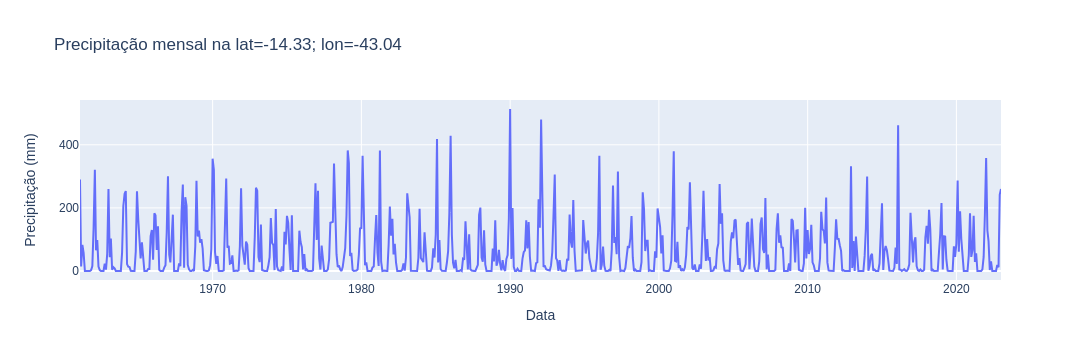

In [34]:
# Plotando mensal
fig = px.line(df_mes, x=df_mes.index, 
              y='Precipitação (mm)',
              title=f"Precipitação mensal na lat={lon_lat[1]}; lon={lon_lat[0]}")
fig.update_traces(hovertemplate="Data: %{x} <br>prec: %{y:.1f} mm")
fig.show()

## Agregando dados diários para anual e plotando

In [35]:
df_ano = df.resample('Y').sum()
df_ano

,Precipitação (mm)
Data,
1961-12-31,599.778188
1962-12-31,843.668395
1963-12-31,434.229761
1964-12-31,1024.769806
1965-12-31,538.891469
...,...
2018-12-31,812.768403
2019-12-31,469.867753
2020-12-31,960.882355


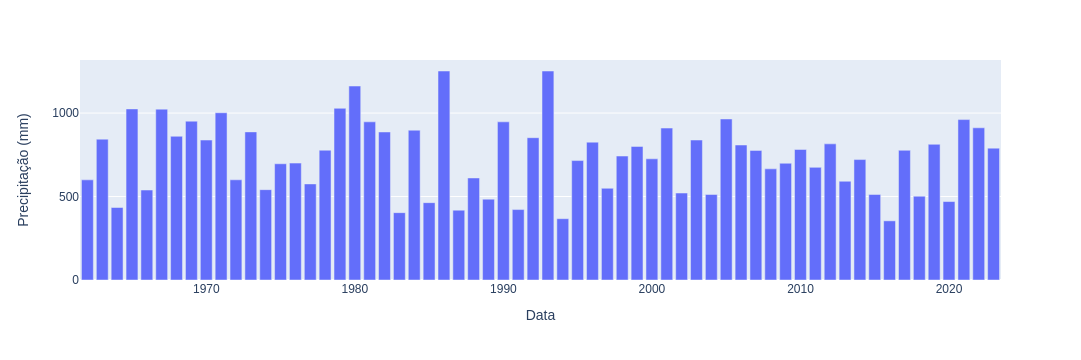

In [36]:
# plotando anual
fig = px.bar(df_ano, x=df_ano.index, y='Precipitação (mm)')
fig.update_traces(hovertemplate="Data: %{x} <br>prec: %{y:.0f} mm")
fig.show()